# Data Analysis - Velib Project in <a href="https://cran.r-project.org/"><img src="https://cran.r-project.org/Rlogo.svg" style="max-width: 40px; display: inline" alt="R"/></a>
---

_Authors:_ J. Chevallier (<small>INSA Toulouse</small>), O. Roustant (<small>INSA Toulouse</small>).

We consider the [velib](https://www.velib-metropole.fr/donnees-open-data-gbfs-du-service-velib-metropole) data set, related to the bike sharing system of Paris. The data are loading profiles of the bike stations over one week, collected every hour, from the period Monday 2nd Sept. - Sunday 7th Sept., 2014. The loading profile of a station, or simply loading, is defined as the ratio of number of available bikes divided by the number of bike docks. A loading of 1 means that the station is fully loaded, i.e. all bikes are available. A loading of 0 means that the station is empty, all bikes have been rent.

From the viewpoint of data analysis, the individuals are the stations. The variables are the 168 time steps (hours in the week). **The aim is to detect clusters in the data, corresponding to common customer usages.** This clustering should then be used to predict the loading profile.

---

The aim of this tutorial is to reproduce the study we carried out in [Python](https://plmlab.math.cnrs.fr/wikistat/Exploration/-/blob/master/Velib/PT_velib_Python.ipynb) on R.

As before, you can find suggested corrections in the "solutions" file. Try to find the answers yourself first! (that's how we make progress). Unfortunately, in `R` the magic `%load` command does not work, so you will have to retrieve the solutions manually.

In [1]:
rm(list = ls())   # erase everything, start from scratch!
# If factoextra not available, run this snippett into the terminal:
# ! sudo apt-get update
# ! sudo apt-get -y install libnlopt-dev


In [2]:
# install.packages('gridExtra')
# install.packages('ggplot2')
# install.packages('reshape2')
# install.packages('ggmap')
# install.packages('emmeans')
# # install.packages('estimability')
# install.packages("FactoMineR")
# # install.packages("factoextra")
# # manual install package estimability
# install.packages("https://cran.r-project.org/src/contrib/Archive/estimability/estimability_1.4.1.tar.gz", repos = NULL, type = "source")
install.packages('https://cran.r-project.org/src/contrib/curl_5.2.1.tar.gz', repos = NULL, type = 'source')


Warning message in install.packages("https://cran.r-project.org/src/contrib/curl_5.2.1.tar.gz", :
“l'installation du package ‘/var/folders/fp/j8_7xh5s5h535x1d0jnd66j80000gn/T//Rtmp8iqrUG/downloaded_packages/curl_5.2.1.tar.gz’ a eu un statut de sortie non nul”


In [3]:
library(ggplot2)
library(reshape2)
library(gridExtra)
library(factoextra)
library(FactoMineR)


Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa



In [4]:
# direct loading from stored data on PLMlab
load('data/velib.RData')
summary(velib)

# alternative: load the data from package funFEM, where you have more information (help page)
# library(funFEM)
# data(velib)
# help("velib")

         Length Class      Mode     
data      181   data.frame list     
position    2   data.frame list     
dates     181   -none-     character
bonus    1189   -none-     numeric  
names    1189   -none-     character

In [5]:
# data preparation
loading = as.matrix(velib$data)
colnames(loading) = 1:ncol(loading)
rownames(loading) = velib$names

stations = 1:nrow(loading)
coord = velib$position[stations,]
coord$bonus = velib$bonus[stations]

# select exactly 7 days of data (we remove the first 13 dates)
dates = 14:181
loading = loading[stations, dates]
colnames(loading) = 1:length(dates)

head(loading)
head(coord)


1          2          3          4          5         
 EURYALE DEHAYNIN    0.03846154 0.03846154 0.07692308 0.03846154 0.03846154
 LEMERCIER           0.47826087 0.47826087 0.47826087 0.43478261 0.43478261
 MEZIERES RENNES     0.21818182 0.14545455 0.12727273 0.10909091 0.10909091
 FARMAN              0.95238095 0.95238095 0.95238095 0.95238095 0.95238095
 QUAI DE LA RAPEE    0.92753623 0.81159420 0.73913043 0.72463768 0.72463768
 CHOISY POINT D'IVRY 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667
                     6          7          8          9          10         ⋯
 EURYALE DEHAYNIN    0.03846154 0.03846154 0.03846154 0.10714286 0.00000000 ⋯
 LEMERCIER           0.43478261 0.43478261 0.43478261 0.26086957 0.04347826 ⋯
 MEZIERES RENNES     0.10909091 0.09090909 0.09090909 0.05454545 0.10909091 ⋯
 FARMAN              0.95238095 0.95238095 1.00000000 1.00000000 1.00000000 ⋯
 QUAI DE LA RAPEE    0.72463768 0.72463768 0.72463768 0.75362319 0.97101449 ⋯
 CHOISY POINT D'IVRY 0.16666667 0.16666667 0.16666667 0.08333333 0.00000000 ⋯
                     159        160        161       162        163       
 EURYALE DEHAYNIN    0.29629630 0.11111111 0.1111111 0.14814815 0.30769231
 LEMERCIER           0.04347826 0.00000000 0.2173913 0.13043478 0.04545455
 MEZIERES RENNES     0.25925926 0.25925926 0.2037037 0.12962963 0.14814815
 FARMAN              1.00000000 1.00000000 0.9047619 0.85714286 0.85714286
 QUAI DE LA RAPEE    0.22727273 0.45454545 0.5909091 0.83333333 1.00000000
 CHOISY POINT D'IVRY 0.34782609 0.08695652 0.1153846 0.08695652 0.13043478
                     164        165        166        167       168      
 EURYALE DEHAYNIN    0.07692308 0.11538462 0.07692308 0.1538462 0.1538462
 LEMERCIER           0.17391304 0.17391304 0.17391304 0.2608696 0.3913043
 MEZIERES RENNES     0.29629630 0.31481481 0.37037037 0.3703704 0.4074074
 FARMAN              0.85714286 0.76190476 0.76190476 0.7619048 0.7619048
 QUAI DE LA RAPEE    0.81818182 0.63636364 0.71212121 0.6212121 0.5757576
 CHOISY POINT D'IVRY 0.08695652 0.08695652 0.43478261 0.3913043 0.5217391

longitude latitude bonus
19117 2.377389  48.88630 0    
17111 2.317591  48.89002 0    
6103  2.330447  48.85030 0    
15042 2.271396  48.83373 0    
12003 2.366897  48.84589 0    
13038 2.363335  48.82191 0

## First Insights into the Dataset

##### <span style="color:purple"> **Todo:** Plot the loading a station</span>

- Plot the load evolution of the $i$-th station over time;
- Draw a vertical line to delimit the days (_**Hint:** How many days do we observe?_);
- Enter the station name in the figure title;
- Label the axes in the figure.

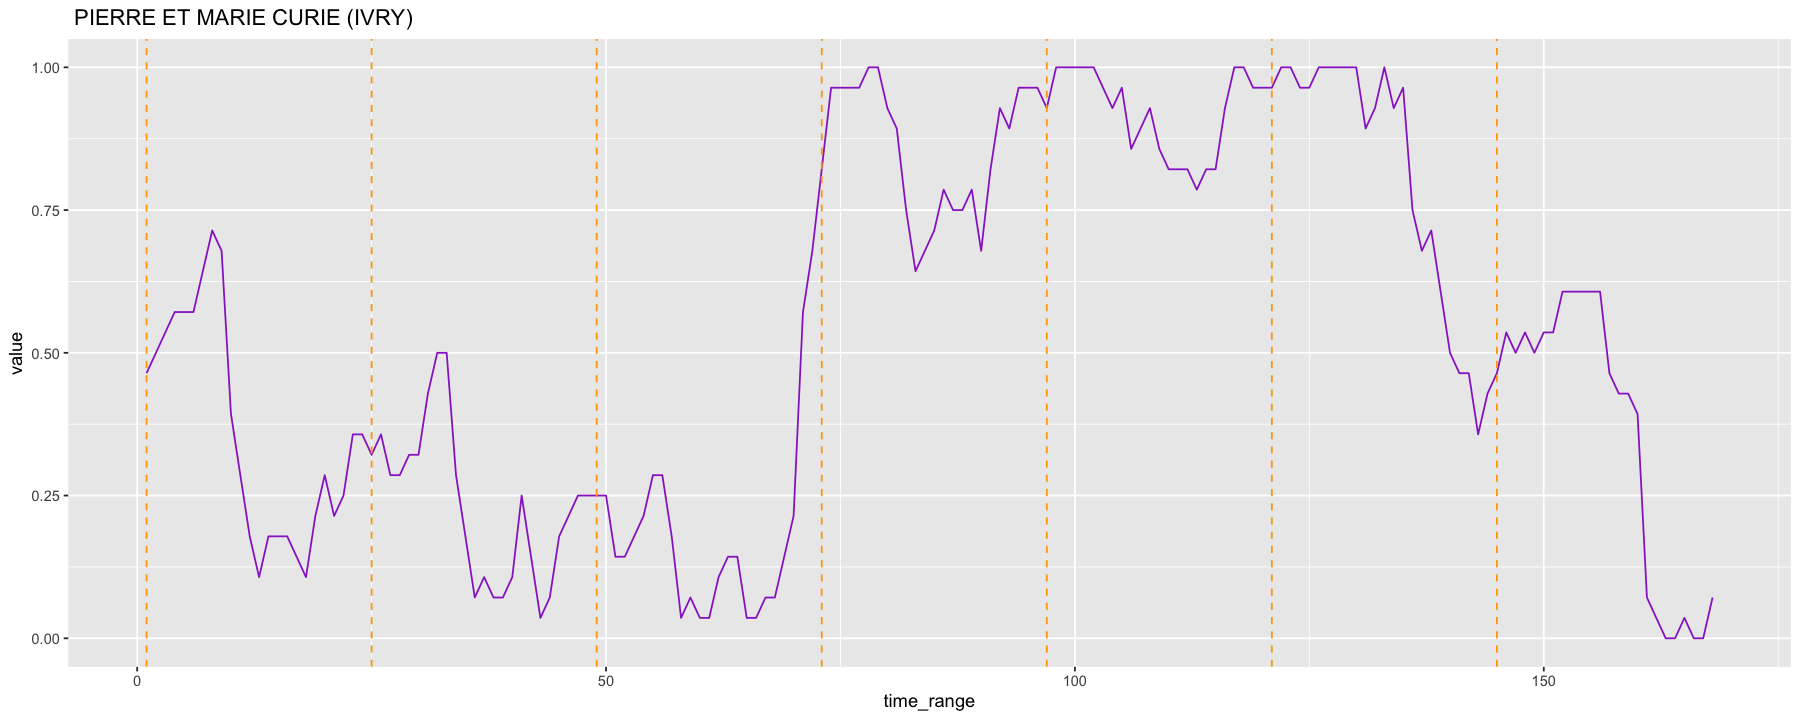

In [6]:
### TO BE COMPLETED ### 

# i = ...

options(repr.plot.width = 15, repr.plot.height = 6)   # Comme plt.figure(15, 6)

# --- #

time_tick = 1 + 24*(0:6)  # vector corresponding to the beginning of days

# select a station
i = sample.int(nrow(loading), 1)    # Fetches a vector of ints of size & from index 1 to n_row(loading) 

df = melt(loading[i,])  #the function melt reshapes it from wide to long (like np.reshape?)
df$time_range = 1:ncol(loading)

ggplot(df, aes(x=time_range, y=value)) + geom_line(col="darkorchid") +
    geom_vline(xintercept=time_tick, col="orange", linetype="dashed") +
    labs(title=velib$names[i])

In [7]:
# solutions/R/plot_loading.r

> Comments?

##### <span style="color:purple"> **Question:** Does loading differ from one station to another?</span>

 Draw a matrix of plots of size 4*4 corresponding to 16 stations of your choice. _Do not forget the vertical lines corresponding to days_

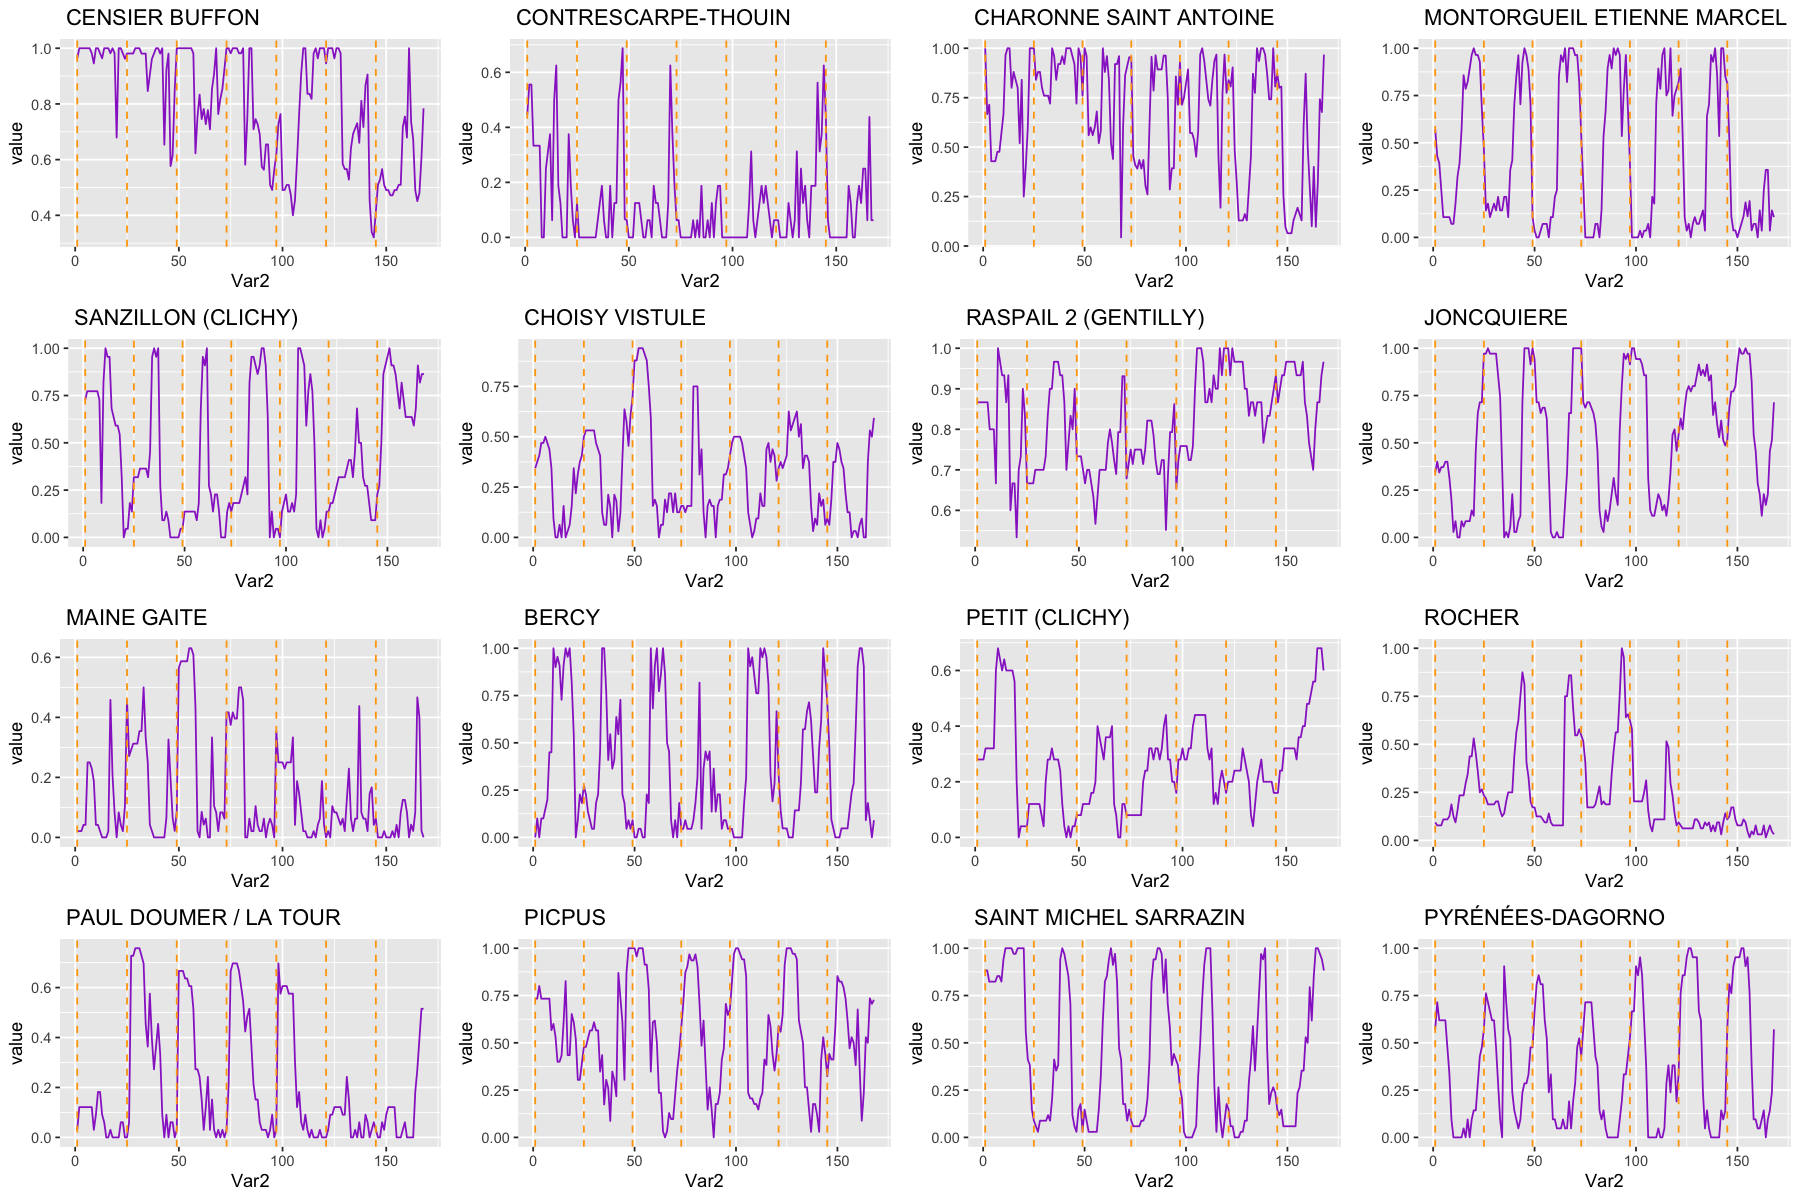

In [8]:
### TO BE COMPLETED ### 

# --- #

options(repr.plot.width = 15, repr.plot.height = 10)

# --- #

timeTick = 1 + 24*(0:6)  # vector corresponding to the beginning of days

# select 16 stations
stations = sample.int(nrow(loading), 16)

df = melt(loading[stations,])  #the function melt reshapes it from wide to long

p = list()
for (i in 1:16){
    dfi = df[df$Var1 == velib$names[stations[i]],]
    p[[i]] = ggplot(dfi, aes(x=Var2, y=value)) + 
        geom_line(col="darkorchid") + 
        geom_vline(xintercept=timeTick, col="orange", linetype="dashed") +
        labs(title=velib$names[stations[i]])
}
do.call(grid.arrange,p)

In [9]:
# solutions/R/plot_loading_16.r

> Comments?

##### <span style="color:purple"> **Todo:** Draw the boxplot of the variables, sorted in time order.</span>

1. What can you say about the distribution of the variables? 
2. Position, dispersion, symmetry? 
3. Can you see a difference between days?

_Hint:_ To change the graphical properties of boxplots (for example, the thickness of the median), use the [`patch_artist = True`](https://python-charts.com/distribution/box-plot-matplotlib/) argument in the `plt.boxplot` function.

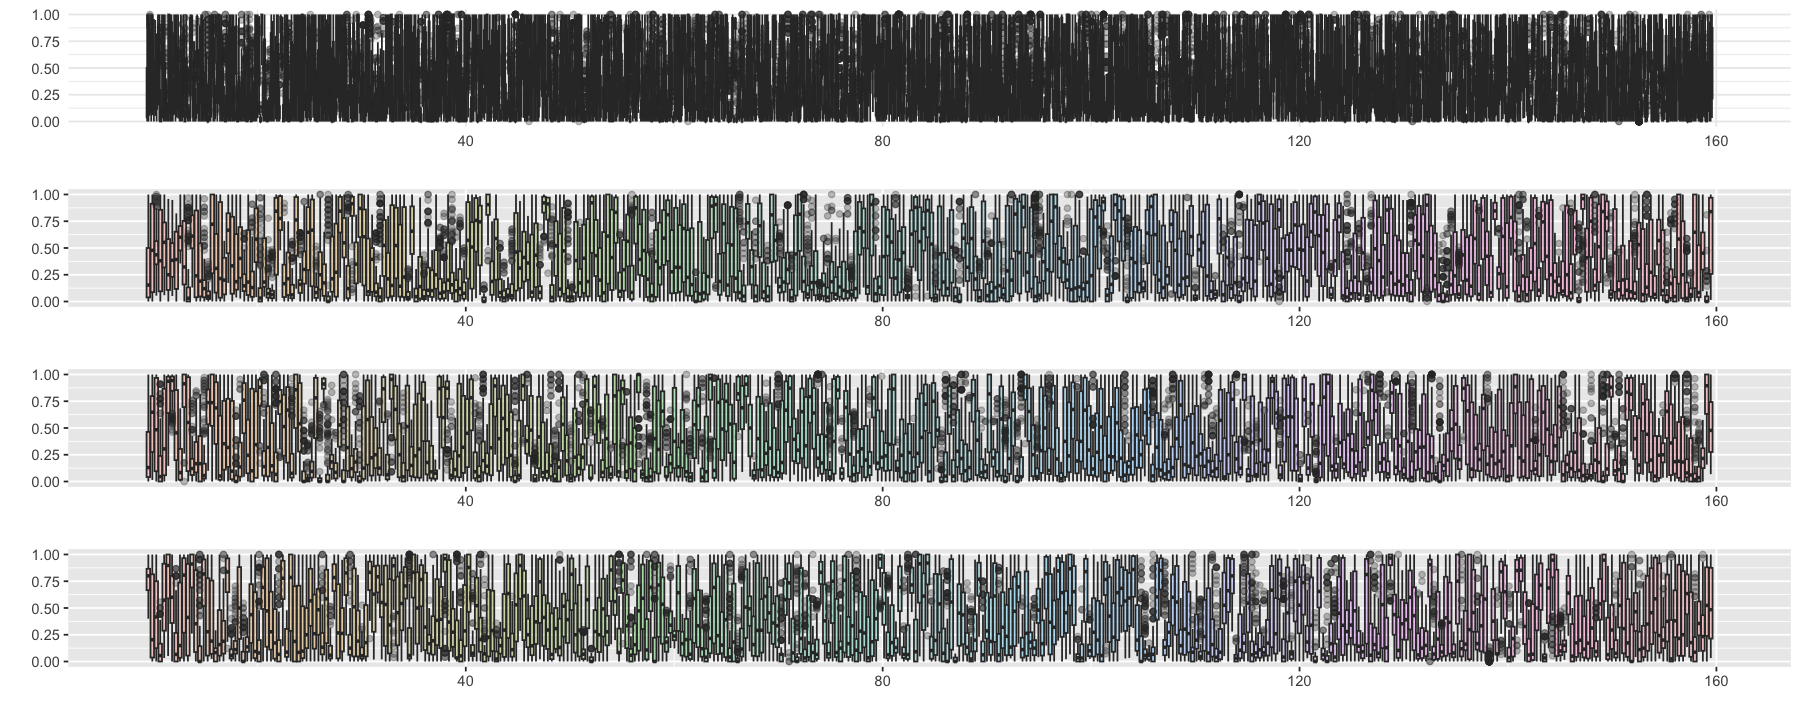

In [10]:
### TO BE COMPLETED ### 

options(repr.plot.width = 15, repr.plot.height = 6)

# --- #

df = melt(loading)
p1 = ggplot(df, aes(x=Var2, y=value, fill=Var1)) + 
    geom_boxplot(alpha=.3, show.legend = FALSE) +
    xlab('') + ylab('') + theme_minimal()

# --- #

# Only a third of the data
df = melt(loading[ seq(from=1, to=+floor(nrow(loading)/3)) ,])
p2 = ggplot(df, aes(x=Var2, y=value, fill=Var1)) + 
    geom_boxplot(alpha=.3, show.legend = FALSE) +
    xlab('') + ylab('')

# The next third
df = melt(loading[ seq(from=1+floor(nrow(loading)/3), to=2*floor(nrow(loading)/3)) ,])
p3 = ggplot(df, aes(x=Var2, y=value, fill=Var1)) + 
    geom_boxplot(alpha=.3, show.legend = FALSE) +
    xlab('') + ylab('')

# The remaining third
df = melt(loading[ seq(from=1+2*floor(nrow(loading)/3), to=nrow(loading)) ,])
p4 = ggplot(df, aes(x=Var2, y=value, fill=Var1)) + 
    geom_boxplot(alpha=.3, show.legend = FALSE) +
    xlab('') + ylab('')

# --- #

grid.arrange(p1, p2, p3, p4, nrow=4)

In [11]:
# solutions/R/plot_loading_disp.r

> Comments?

## Average Loading

##### <span style="color:purple"> **Question:** What is the average station fill rate?</span>

Which station is, on average, the fullest? the least full?

In [12]:
### TO BE COMPLETED ### 

print('--- Average fill rate ---')
print(mean(loading))

# --- #
print('')

print('--- Least crowded station, on average ---')
i = which.min(rowMeans(loading)) #which.min() gives first occuring index of min | rowMeans() gives mean of the rows
print(rowMeans(loading)[i])

# --- #
print('')

print('--- Fullest station, on average ---')
i = which.max(rowMeans(loading))
print(rowMeans(loading)[i])

[1] "--- Average fill rate ---"
[1] 0.3816218
[1] ""
[1] "--- Least crowded station, on average ---"
 HORNET (BAGNOLET) 
        0.01613284 
[1] ""
[1] "--- Fullest station, on average ---"
 INSURRECTION AOUT 1944 (IVRY) 
                     0.9193723 


In [13]:
# solutions/R/loading_mean.r

##### <span style="color:purple"> **Question:** Does the average load vary from one station to another?</span>

- Show the evolution of the average load for each station. 
- On the same graph, plot the average loading for the entire data set.

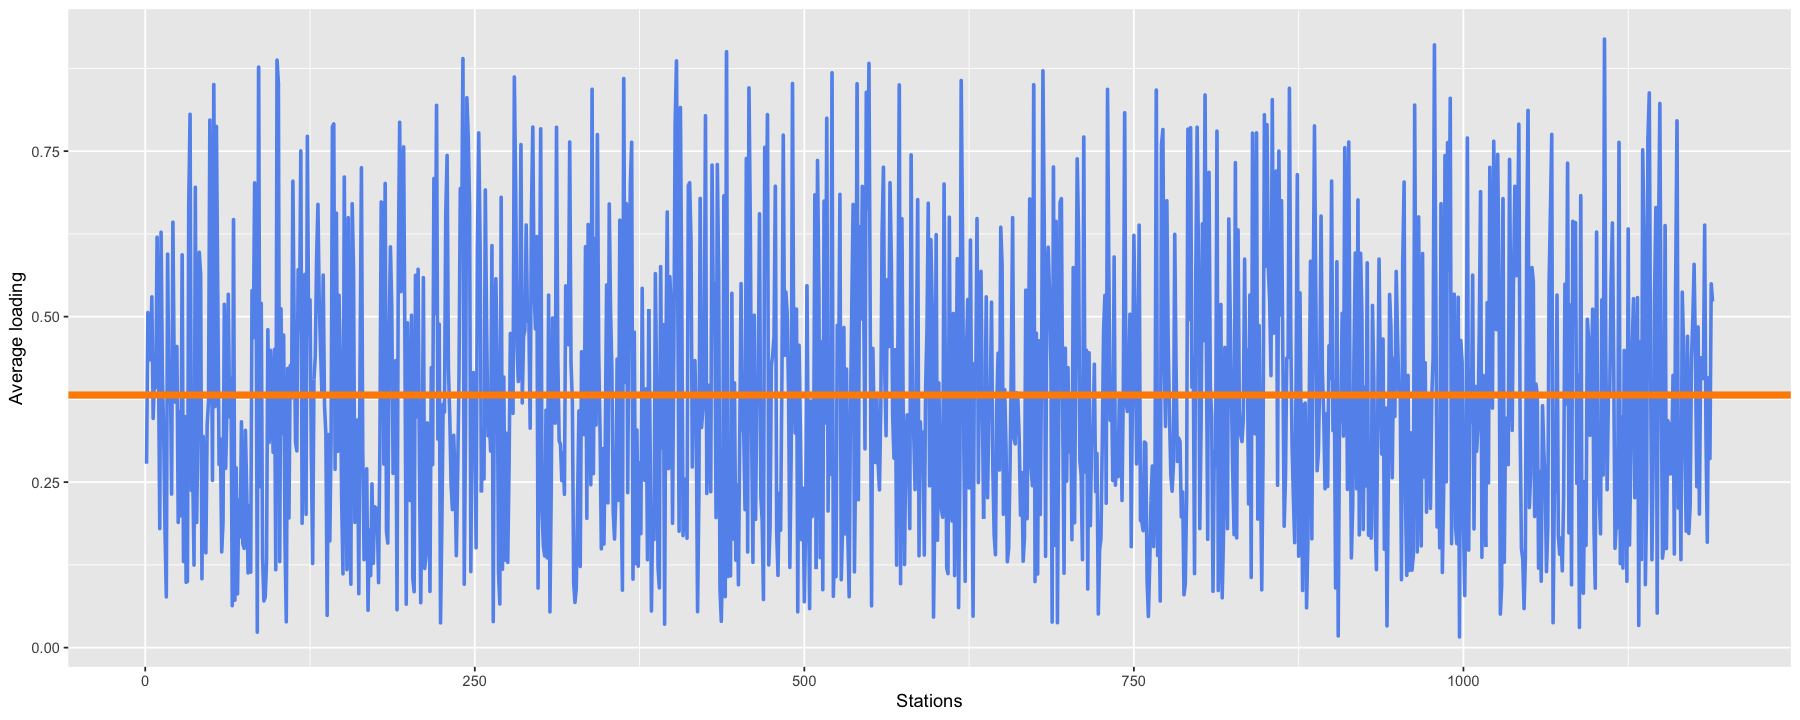

In [14]:
### TO BE COMPLETED ### 

options(repr.plot.width = 15, repr.plot.height = 6)

df = data.frame(stations = c(1:nrow(loading)), mean = rowMeans(loading))
ggplot(df, aes(x = stations, y= mean)) + 
    geom_line(color = 'cornflowerblue', linewidth=1) +
    geom_hline(yintercept = mean(loading), color = 'darkorange', linewidth=2) +
    labs(x = "Stations", y = "Average loading")


In [15]:
# solutions/R/plot_mean_stations.r

> Comments?

##### <span style="color:purple"> **Question:** Does the average load vary over the course of a day?</span>

Plot the average hourly loading for each day (on a single graph).

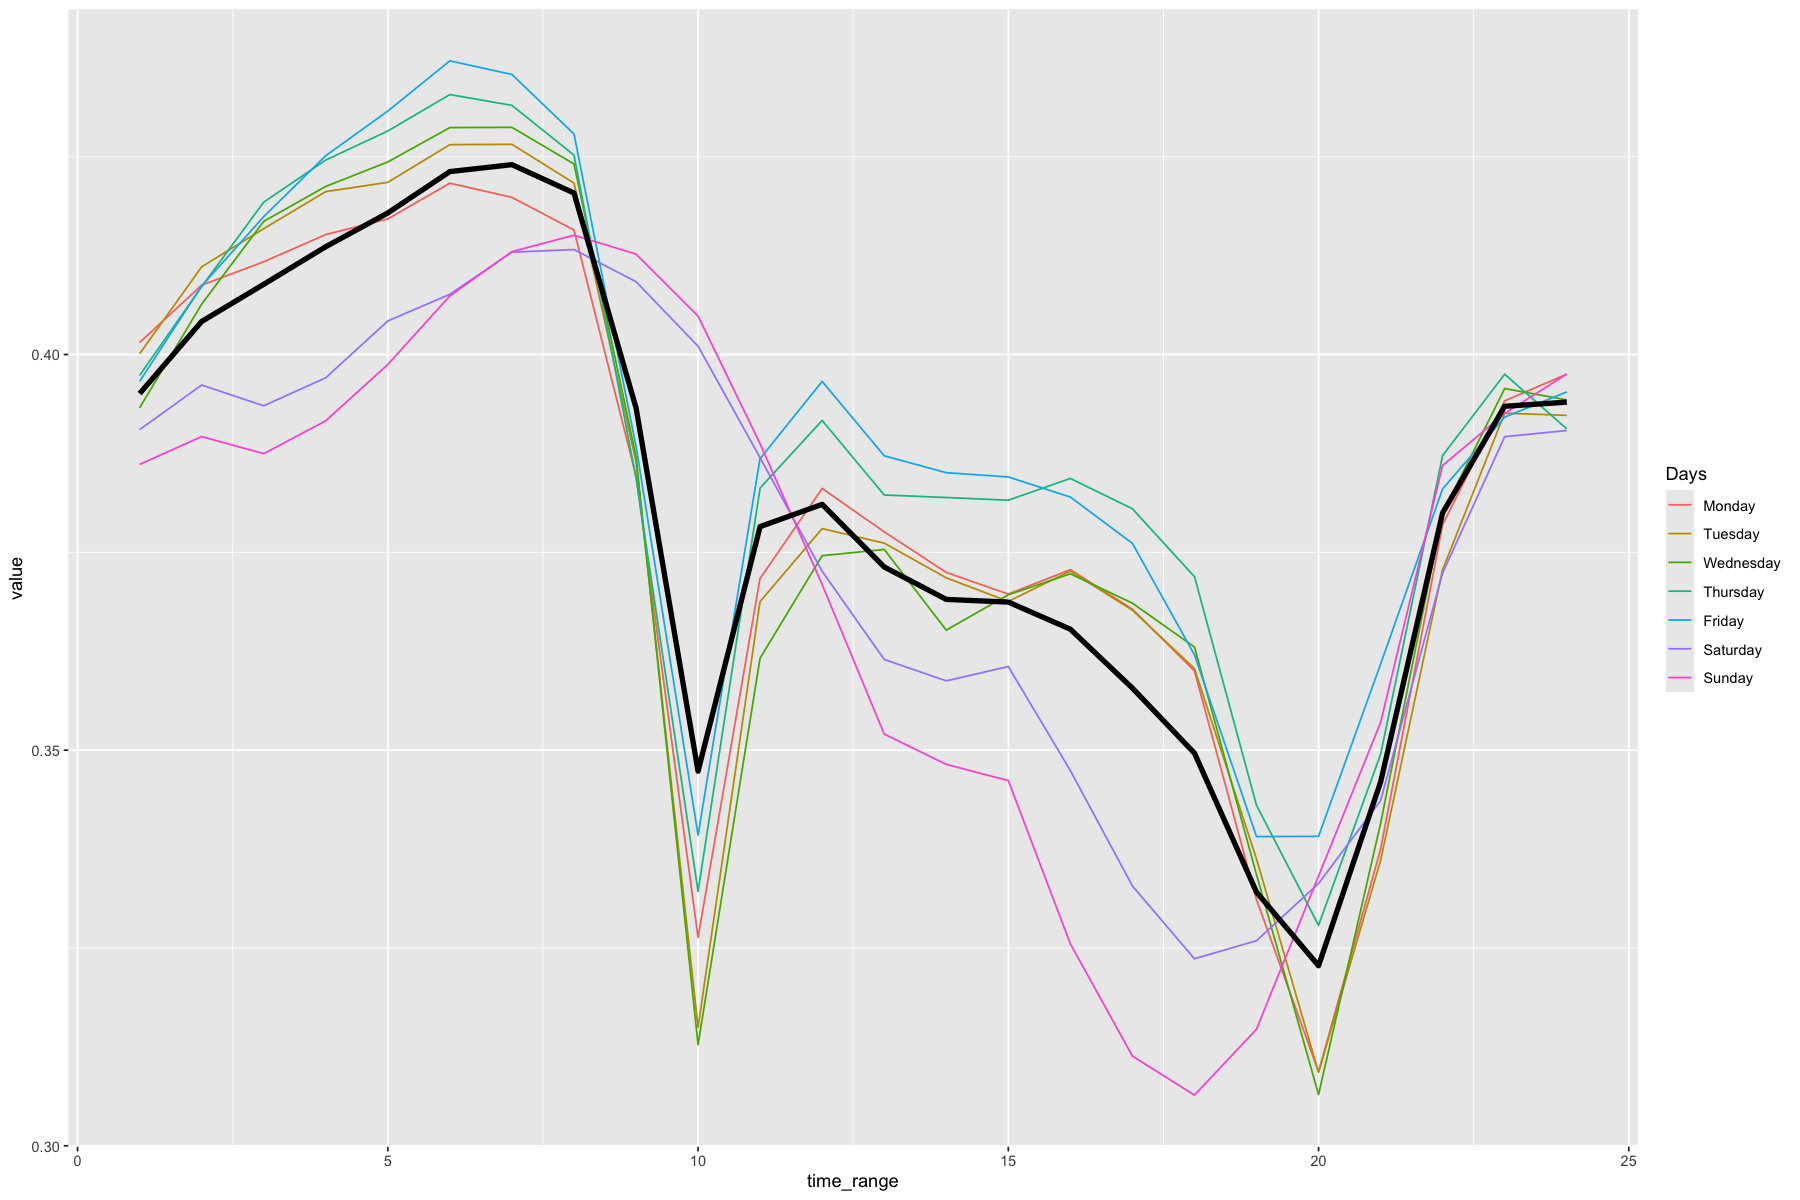

In [16]:
mean_per_hour_per_day = colMeans(loading)
mean_per_hour_per_day = matrix(mean_per_hour_per_day, nrow = 24)
mean_per_hour         = rowMeans(mean_per_hour_per_day)

# --- #

mean_per_hour_per_day            = as.data.frame(mean_per_hour_per_day)
colnames(mean_per_hour_per_day)  = list("Monday", "Tuesday", "Wednesday","Thursday", "Friday", "Saturday", "Sunday")
mean_per_hour_per_day$time_range = c(1:24)
mean_per_hour_per_day            = melt(mean_per_hour_per_day, id='time_range', variable.name='Days')

mean_per_hour            = as.data.frame(mean_per_hour)
colnames(mean_per_hour)  = list("Weekly")
mean_per_hour$time_range = c(1:24)

# --- #

options(repr.plot.width = 15, repr.plot.height = 10)

ggplot() + 
    geom_line(data=mean_per_hour_per_day, aes(x=time_range, y=value, color=Days)) + 
    geom_line(data=mean_per_hour, aes(x=time_range, y=Weekly), linewidth = 1.5)

In [17]:
# solutions/R/plot_mean_hours.r

> Comments?

## Velib Station Map

In [19]:
library(ggmap)
# Remember to remobve the API-key
register_stadiamaps(key = "c254e27b-2d82-45df-9c6d-0a0db3bb1ce9") 

##### <span style="color:purple"> **Question:** Where are the velib stations located?</span>

- Plot the stations coordinates on a 2D map (latitude _vs._ longitude)
- Use the average hourly loading as a color scale
- You can consider different times of day, for example 6am, 12pm, 11pm on Monday, or the average weekly load at 6am.
- You can consider different days at the same time, or the average load for each day.
- You can use the [`qmplot`](https://rdrr.io/cran/ggmap/man/qmplot.html) function of the [`ggmap`](https://github.com/dkahle/ggmap) to charge the map of Paris

---

_**Note**:_ You will need a Stadia Maps API key to access the tiles in `ggmap`. _It is free_, and you will find a guide to obtaining such a key in the [Stadia Maps documentation](https://docs.stadiamaps.com/tutorials/getting-started-in-r-with-ggmap/).

Keep in mind that this key must remain private, and _do not leave it on the notebook to be returned with your project_.

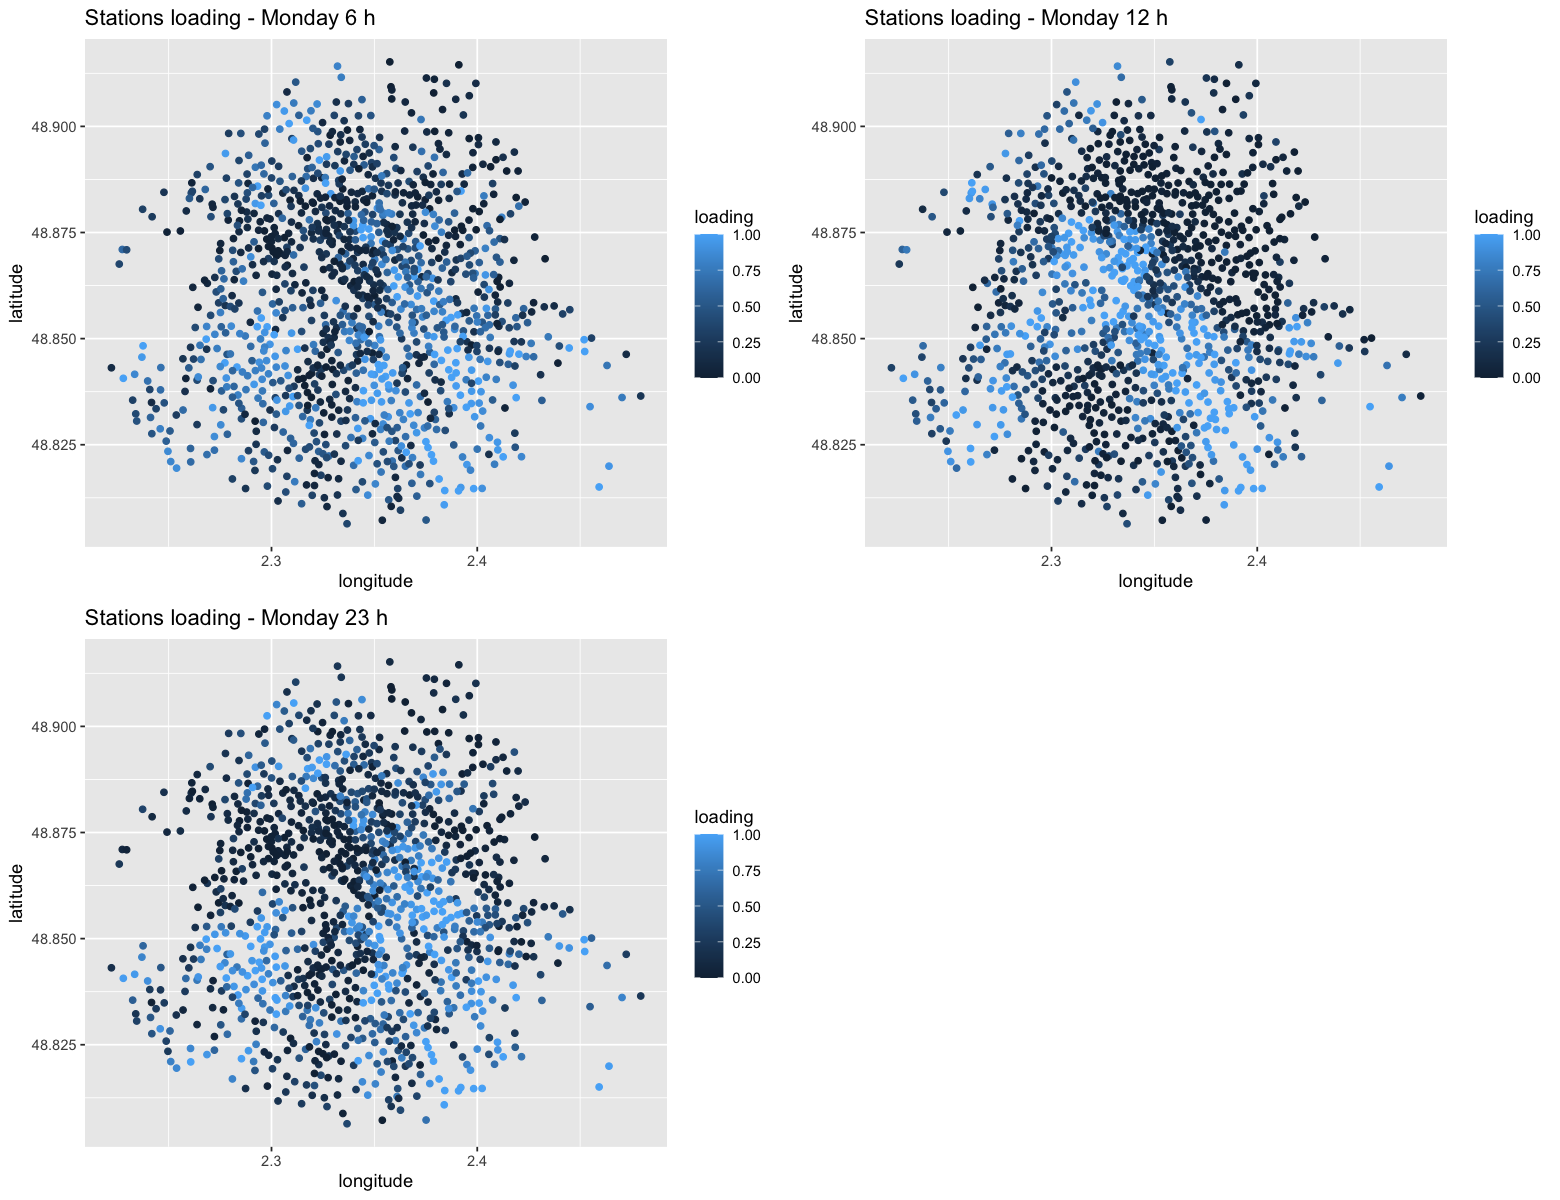

In [20]:
### TO BE COMPLETED ### 
## Simple 2D representation
# Monday at hour 6h, 12h, 23h

# Hours to be displayed
options(repr.plot.width = 13, repr.plot.height = 10)
hours = c(6, 12, 23)

dfi = coord
p = list()
for (i in 1:length(hours)){
    dfi$loading = loading[,hours[i]]
    p[[i]] = ggplot(dfi, aes(x=longitude, y=latitude, color=loading)) + 
        geom_point() +
        labs(title = paste("Stations loading - Monday",hours[i],"h"))
}

do.call(grid.arrange,c(p, ncol=2))

In [ ]:
# solutions/R/plot_loading_2D_monday.r

> Comments?

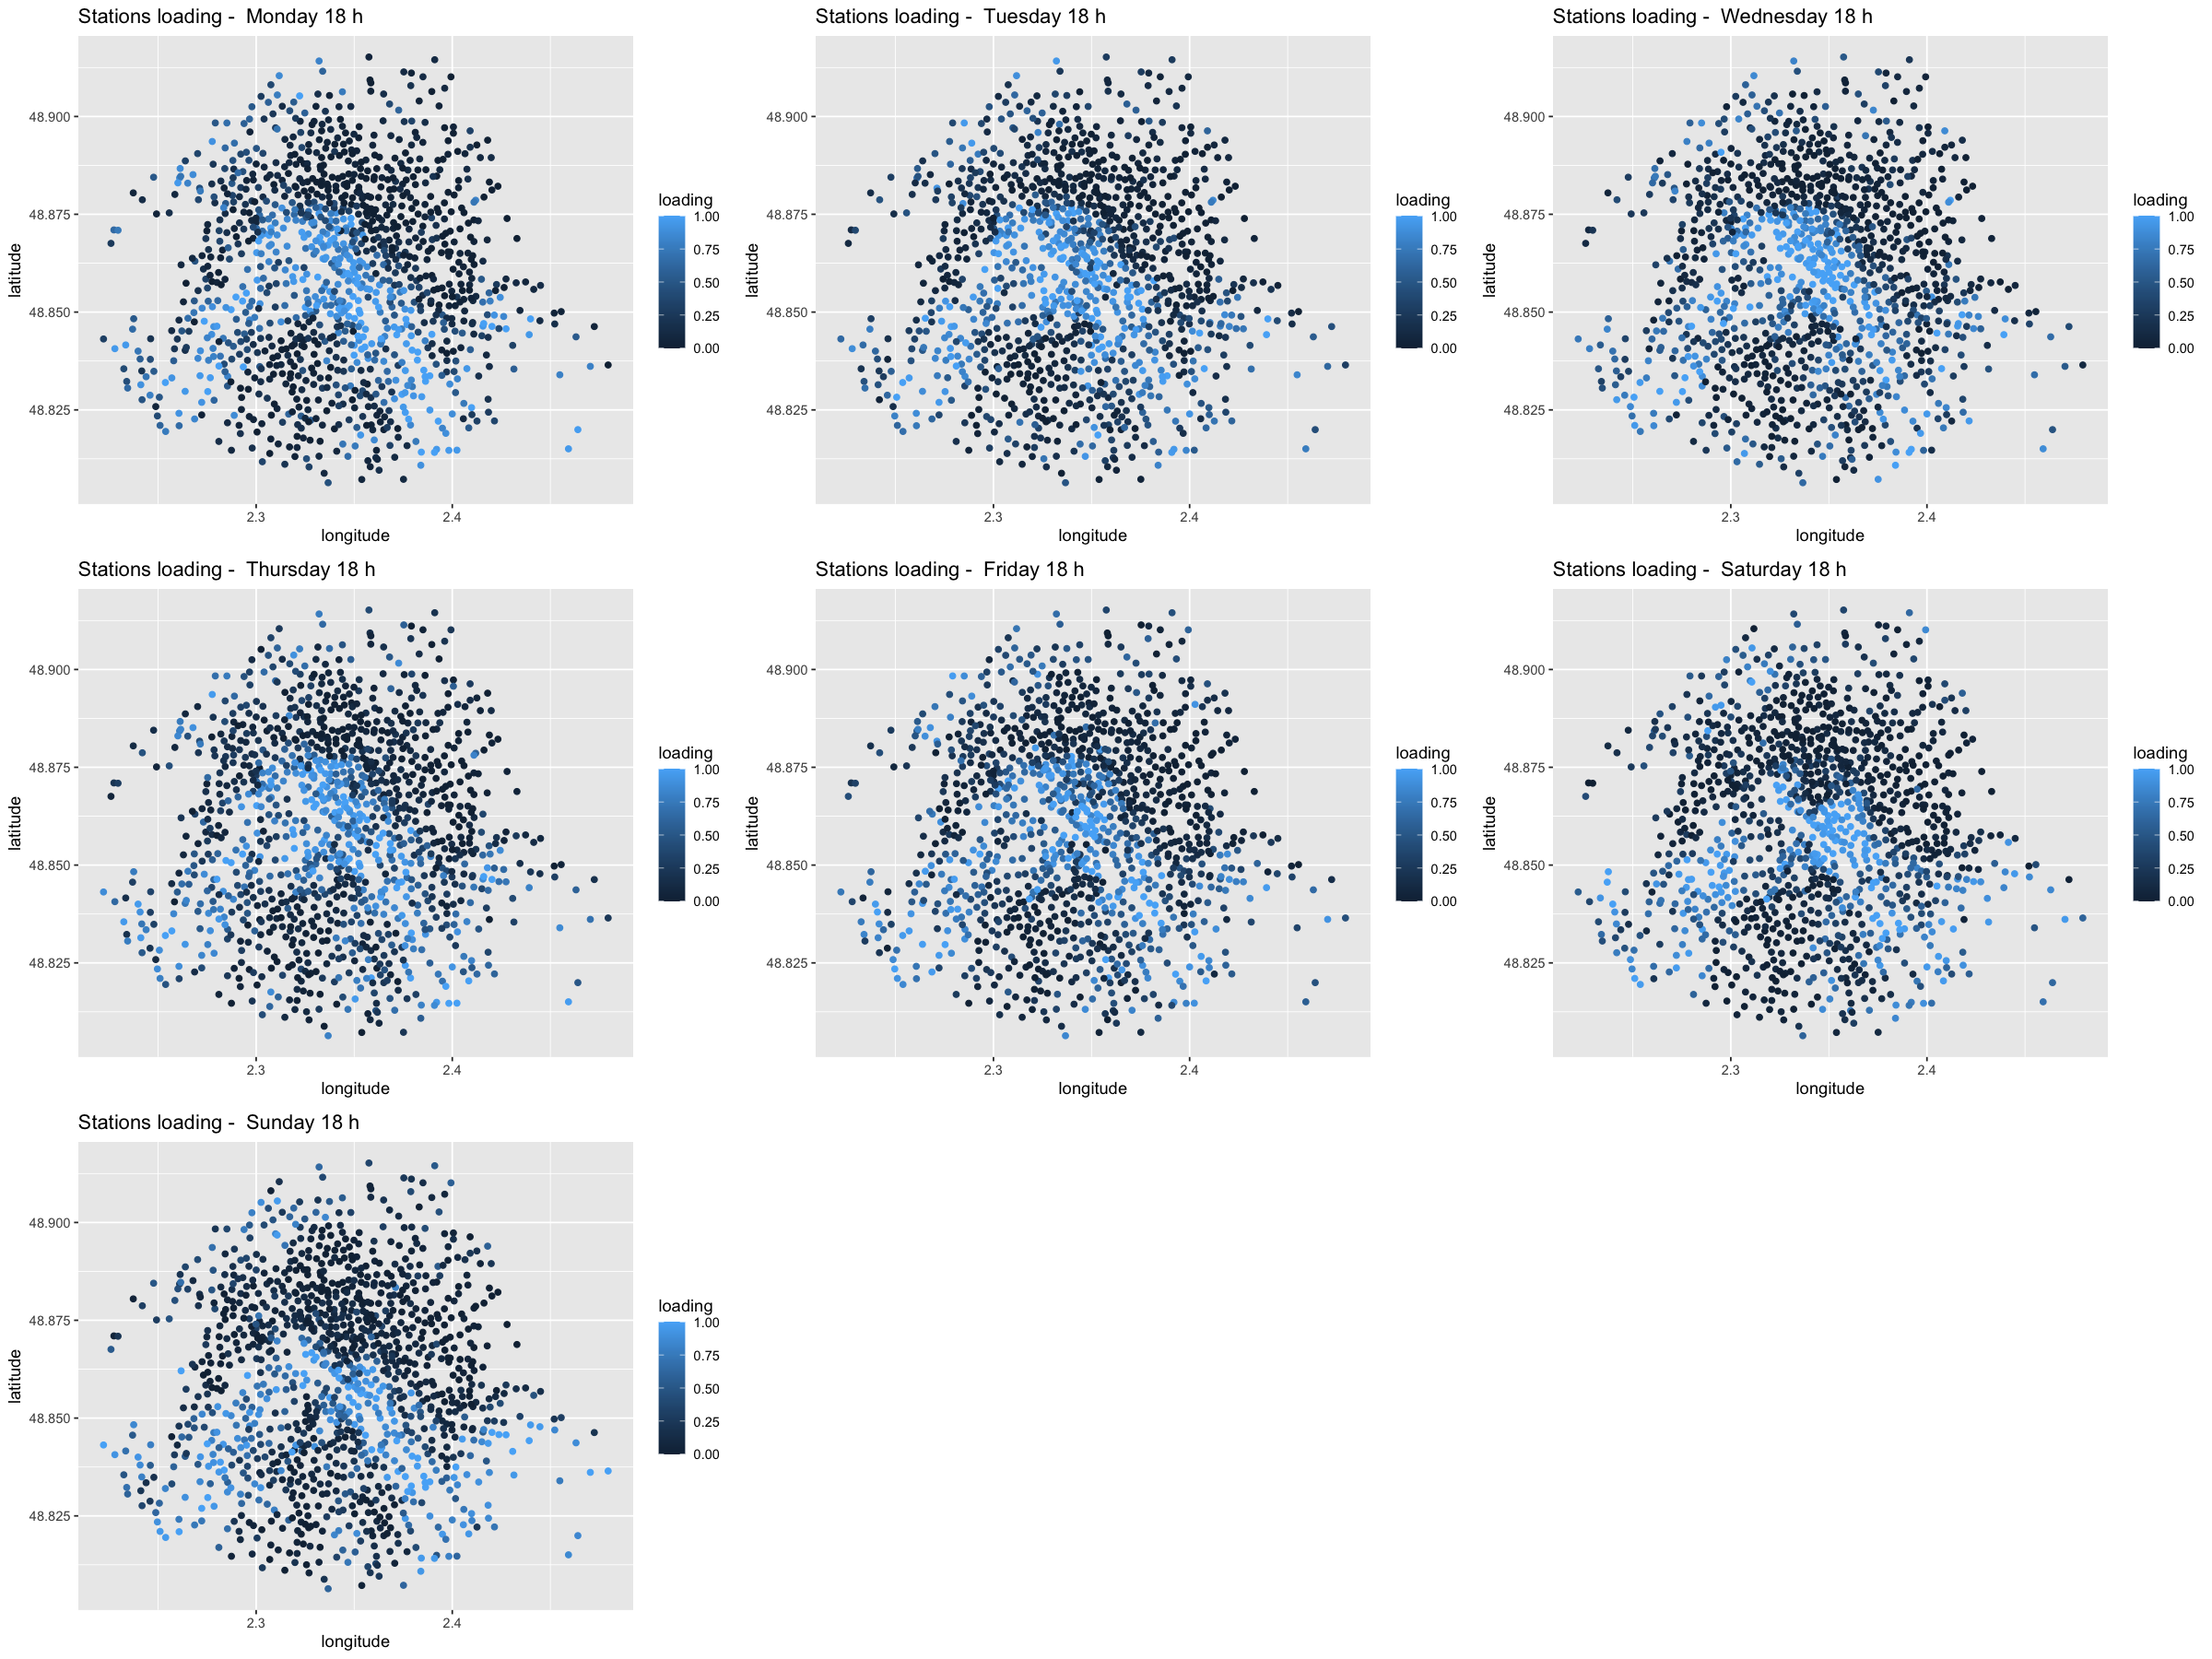

In [21]:
### TO BE COMPLETED ### 
## Simple 2D representation
# Loading at 6pm, depending on the day of the week

options(repr.plot.width = 20, repr.plot.height = 15)

h = 18
hours = seq(h, 168, 24)
days  = list("Monday", "Tuesday", "Wednesday","Thursday", "Friday", "Saturday", "Sunday")

dfi = coord
p = list()
for (i in 1:7){
    dfi$loading = loading[,hours[i]]
    p[[i]] = ggplot(dfi, aes(x=longitude, y=latitude, color=loading)) + 
        geom_point() +
        labs(title = paste("Stations loading - ", days[i], h,"h"))
}

do.call(grid.arrange,c(p, ncol=3))

In [ ]:
# solutions/R/plot_loading_2D_18h.r

> Comments?

In [27]:
install.packages("curl")



  Une version binaire est disponible mais la version du source est plus
  récente:
     binary source needs_compilation
curl  5.2.0  5.2.1              TRUE



installation du package source ‘curl’


Warning message in install.packages("curl"):
“l'installation du package ‘curl’ a eu un statut de sortie non nul”


ℹ Using `zoom = 12`

ℹ © Stadia Maps © Stamen Design © OpenMapTiles © OpenStreetMap contributors.



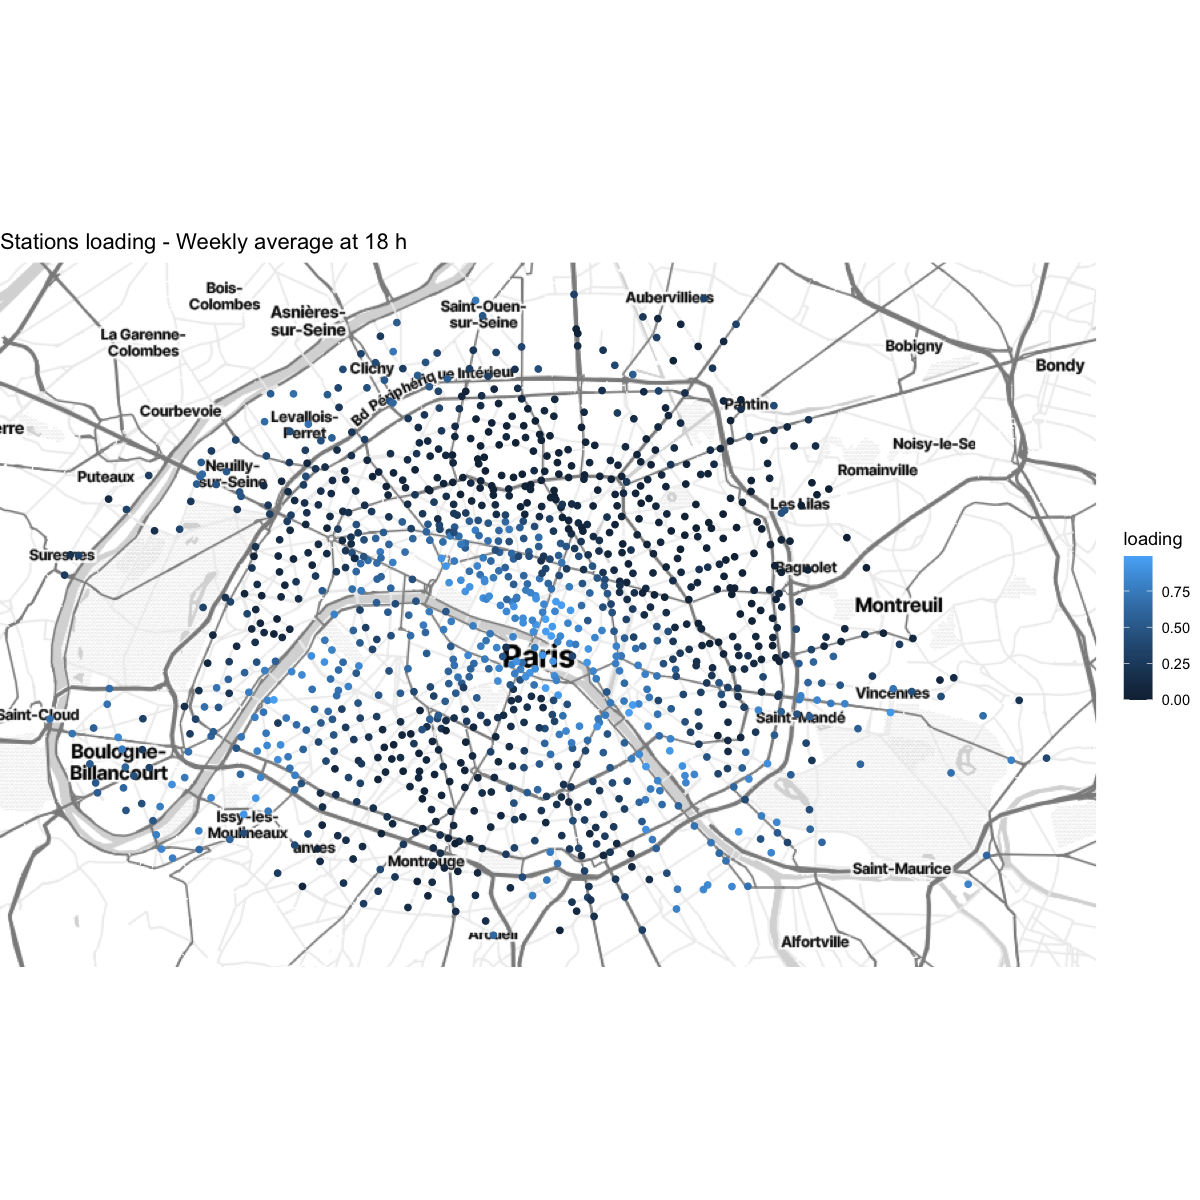

In [22]:
### TO BE COMPLETED ### 
## Visualization on the Paris map
h     = 18
hours = seq(h, 168, 24)
load_per_hour = rowMeans(loading[,hours])

df = coord
df$loading = load_per_hour

# --- #

options(repr.plot.width = 10, repr.plot.height = 10)

qmplot(data=df, longitude, latitude, color=loading) +
    labs(title = paste('Stations loading - Weekly average at',h,'h'))


In [ ]:
# solutions/R/plot_loading_map.r

> Comments?

## Influence of Altitude Difference on Station Loading

##### <span style="color:purple"> **Question:** Does Paris have many hilltop stations?</span>

- Compare the number of hilltop stations with the others.

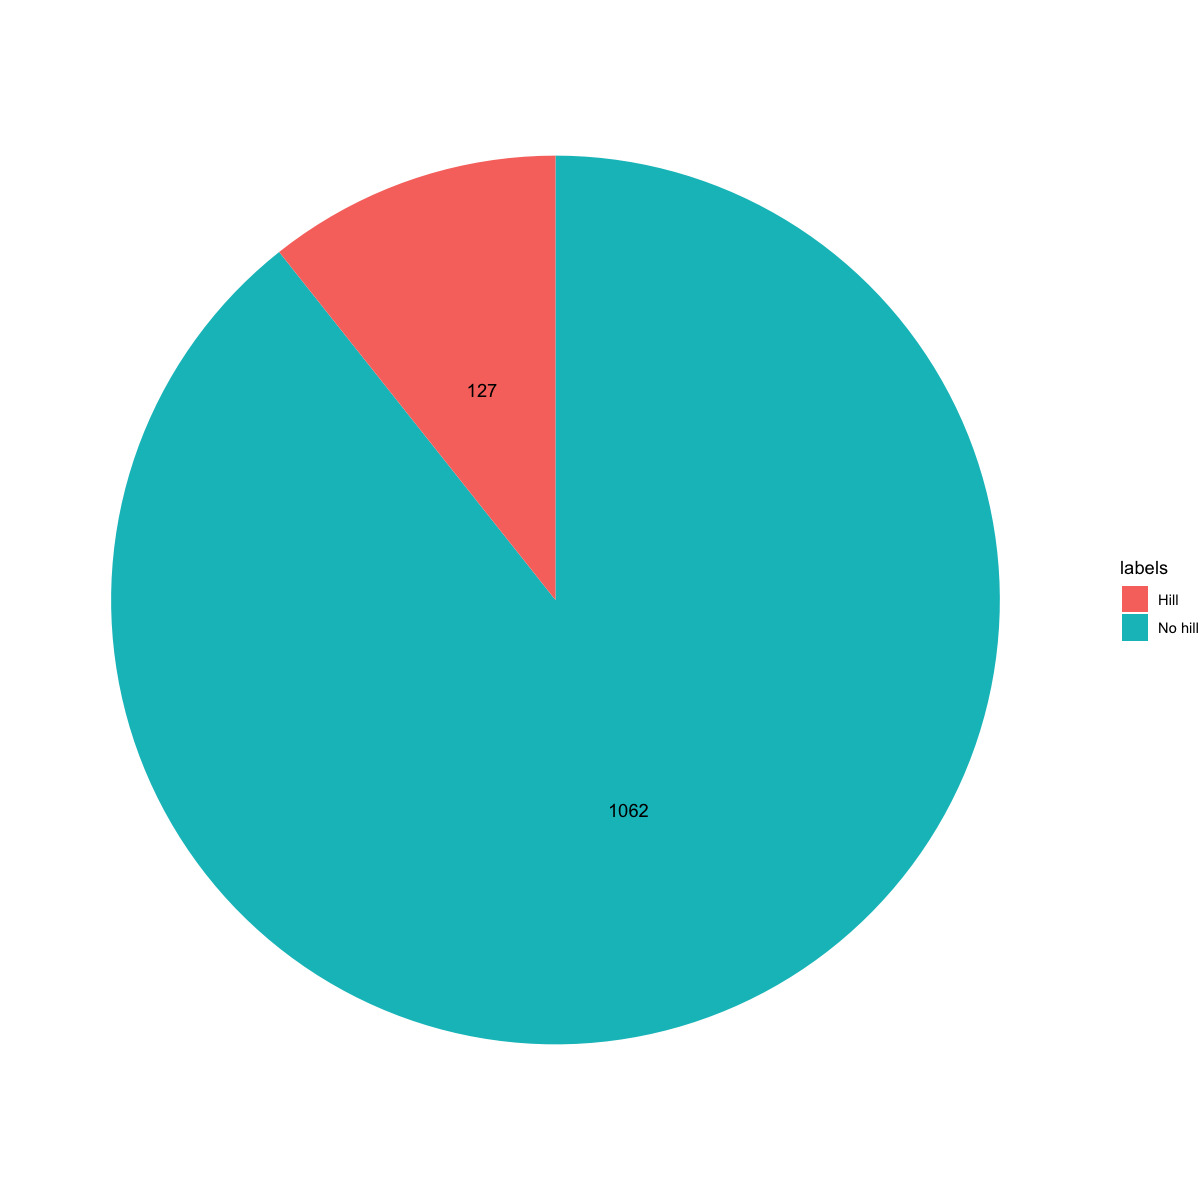

In [23]:
df = data.frame(size=c(sum(coord$bonus==0), sum(coord$bonus==1)),
                labels = c('No hill','Hill'))

ggplot(df, aes(x="", y=size, fill=labels)) +
    geom_bar(stat="identity", width=1) +
    geom_text(aes(label=size), position = position_stack(vjust = 0.5)) +
    coord_polar(theta = "y") +
    scale_color_hue(direction = -1) +  # to reverse the default colormap order
    theme_void()

In [ ]:
# solutions/R/hilltop_stations.r

##### <span style="color:purple"> **Question:** Are hilltop stations more crowded than others?</span>

- Plot the stations coordinates on a 2D map (latitude _vs._ longitude), using a different color for stations which are located on a hill.
- Redo the initial study, but distinguish hilltop stations from others.

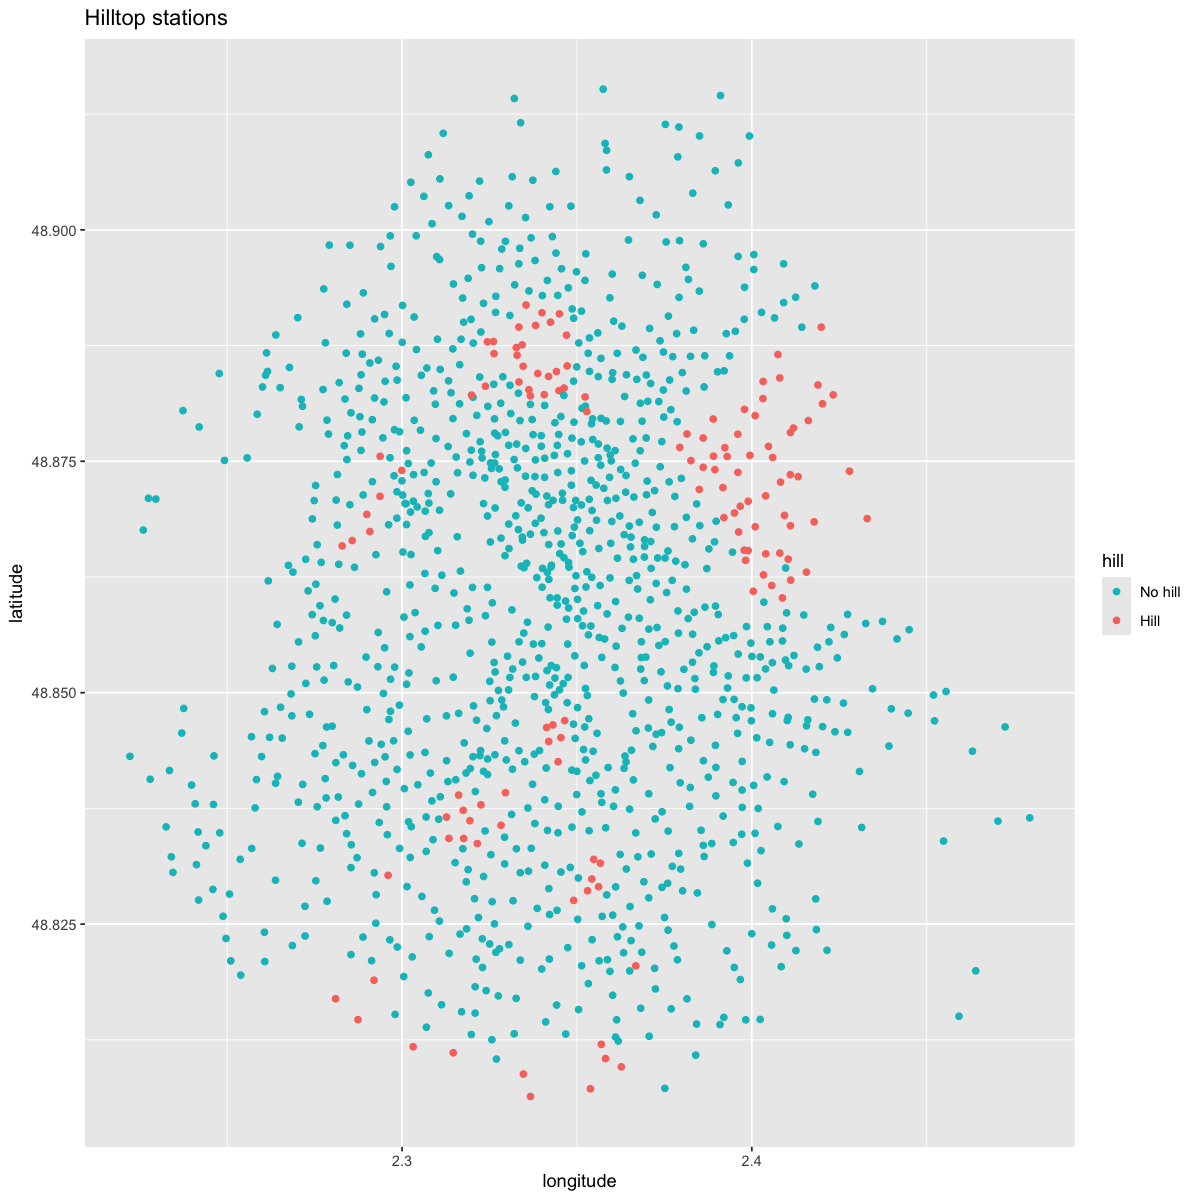

In [24]:
### TO BE COMPLETED ### 
## Simple 2D representation

coord$hill = as.factor(coord$bonus)
levels(coord$hill) = c('No hill','Hill')

# --- #

options(repr.plot.width = 10, repr.plot.height = 10)

ggplot(coord, aes(x=longitude, y=latitude, color=hill)) + 
    geom_point() +
    scale_color_hue(direction = -1) +
    labs(title = 'Hilltop stations')

In [ ]:
# solutions/R/hilltop_stations_2D.r

ℹ Using `zoom = 12`

ℹ © Stadia Maps © Stamen Design © OpenMapTiles © OpenStreetMap contributors.



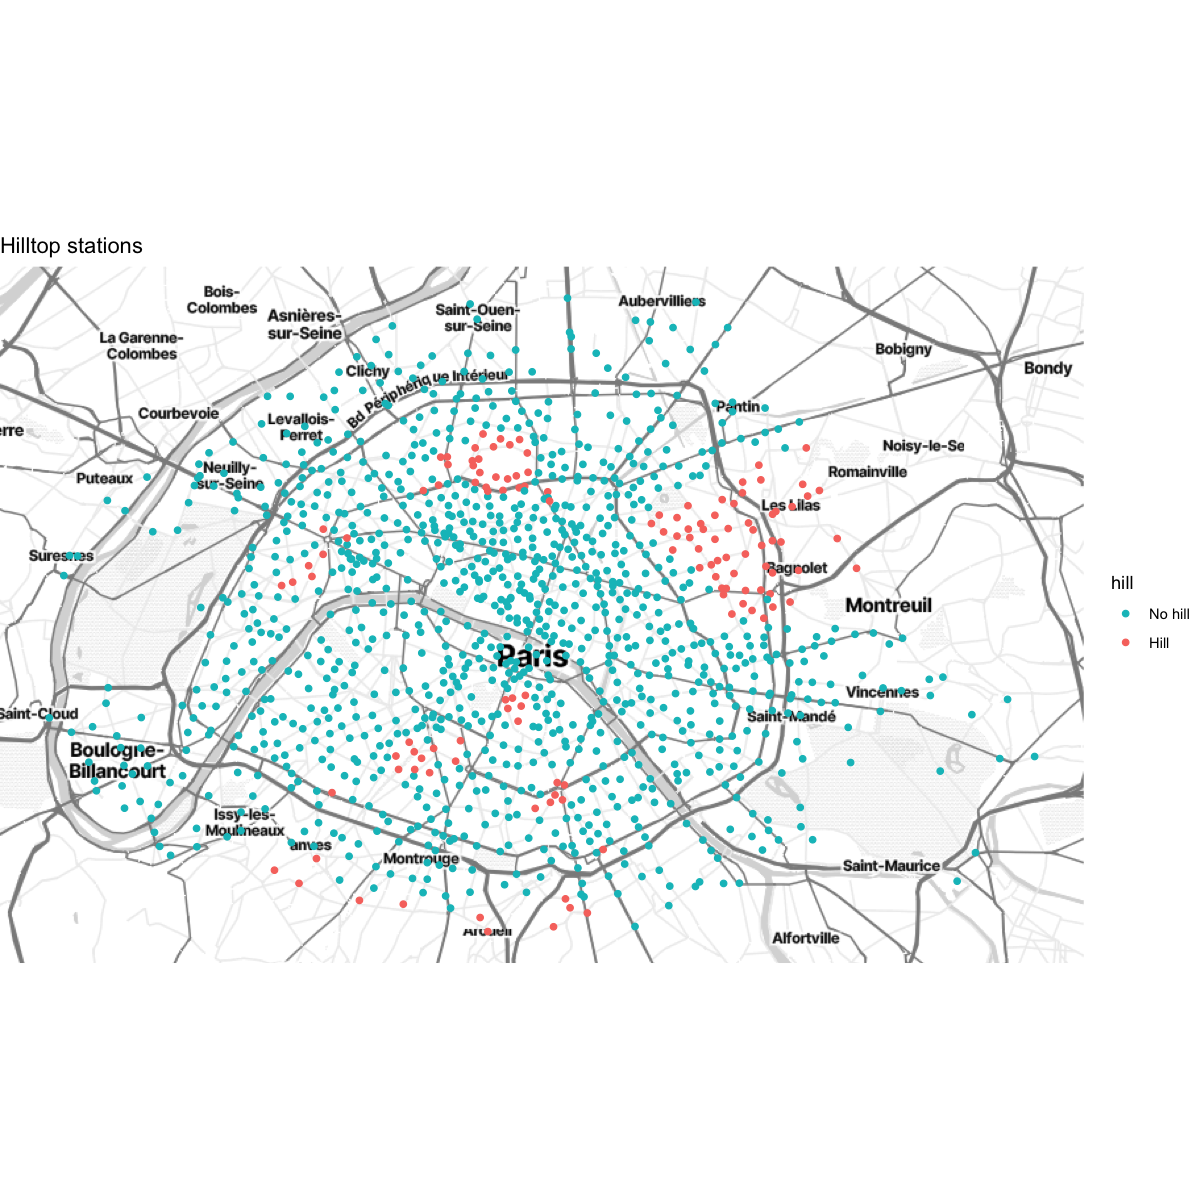

In [25]:
### TO BE COMPLETED ### 
## Visualization on the Paris map

options(repr.plot.width = 10, repr.plot.height = 10)

qmplot(data=coord, longitude, latitude, color=hill) +
    scale_color_hue(direction = -1) +
    labs(title = 'Hilltop stations')

In [ ]:
# solutions/R/hilltop_stations_map.r

In [45]:
# Download package corrr
# install.packages('corrr')
# library(corrr)
install.packages("ggcorrplot")
library(ggcorrplot)


Les packages binaires téléchargés sont dans
	/var/folders/fp/j8_7xh5s5h535x1d0jnd66j80000gn/T//Rtmp8iqrUG/downloaded_packages


Importance of components:
                          PC1    PC2     PC3     PC4     PC5     PC6     PC7
Standard deviation     8.1786 6.2838 2.97786 2.70284 2.34587 1.80159 1.68199
Proportion of Variance 0.3982 0.2350 0.05278 0.04348 0.03276 0.01932 0.01684
Cumulative Proportion  0.3982 0.6332 0.68597 0.72945 0.76221 0.78153 0.79837
                           PC8     PC9    PC10    PC11    PC12    PC13    PC14
Standard deviation     1.63839 1.46881 1.43432 1.29352 1.20705 1.18500 1.10207
Proportion of Variance 0.01598 0.01284 0.01225 0.00996 0.00867 0.00836 0.00723
Cumulative Proportion  0.81435 0.82719 0.83944 0.84940 0.85807 0.86643 0.87366
                         PC15    PC16    PC17    PC18    PC19    PC20    PC21
Standard deviation     1.0768 1.06987 1.02474 0.95996 0.93581 0.81527 0.78680
Proportion of Variance 0.0069 0.00681 0.00625 0.00549 0.00521 0.00396 0.00368
Cumulative Proportion  0.8806 0.88737 0.89362 0.89911 0.90432 0.90828 0.91196
                          PC22   PC23 

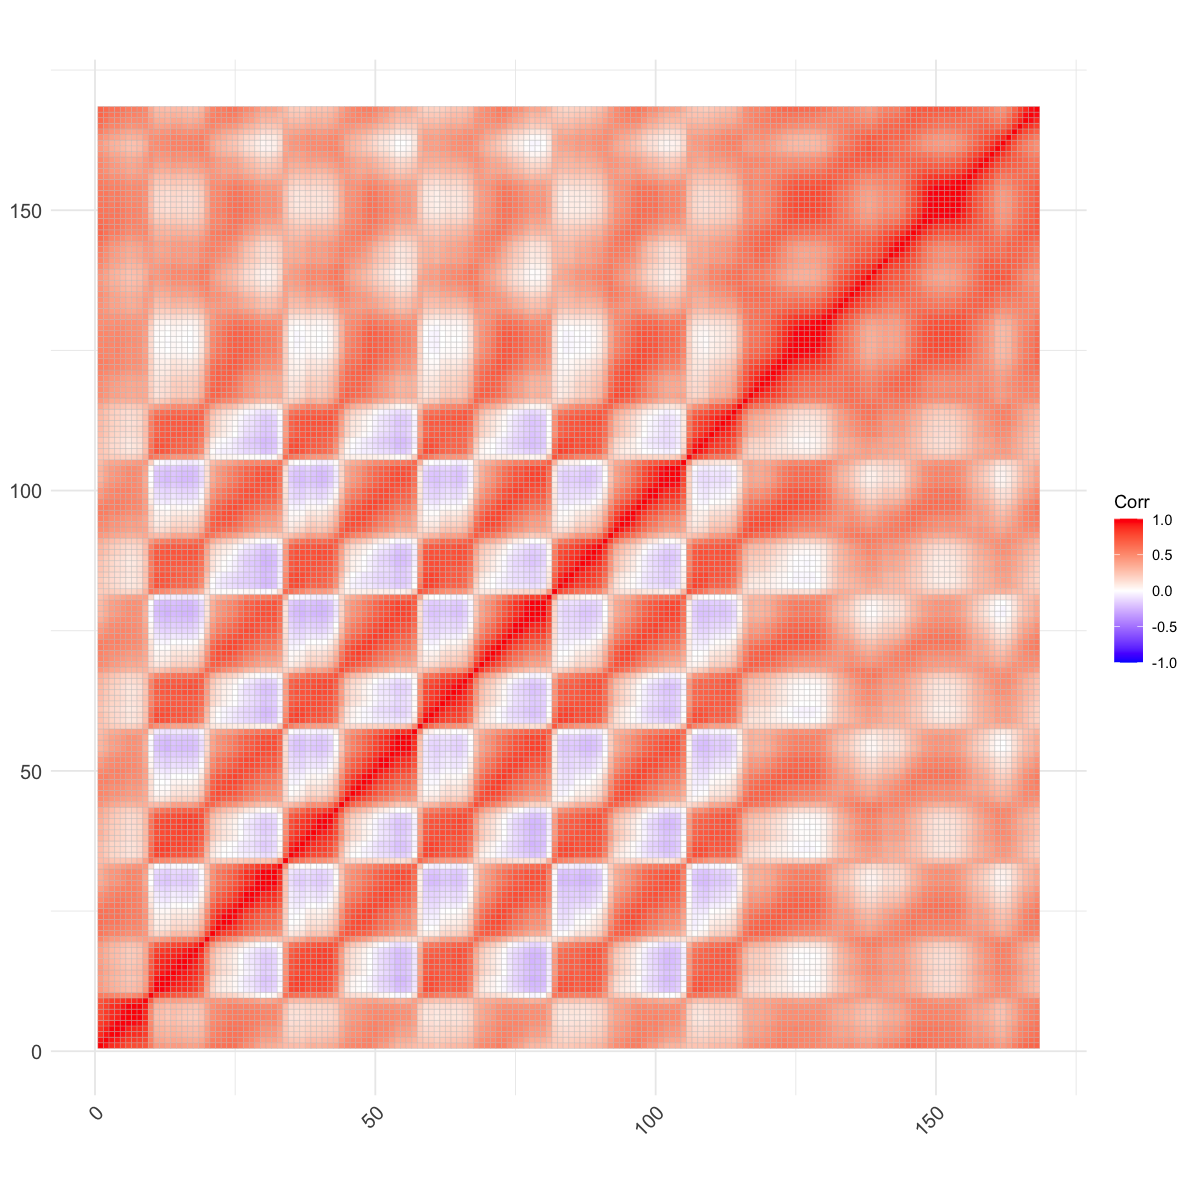

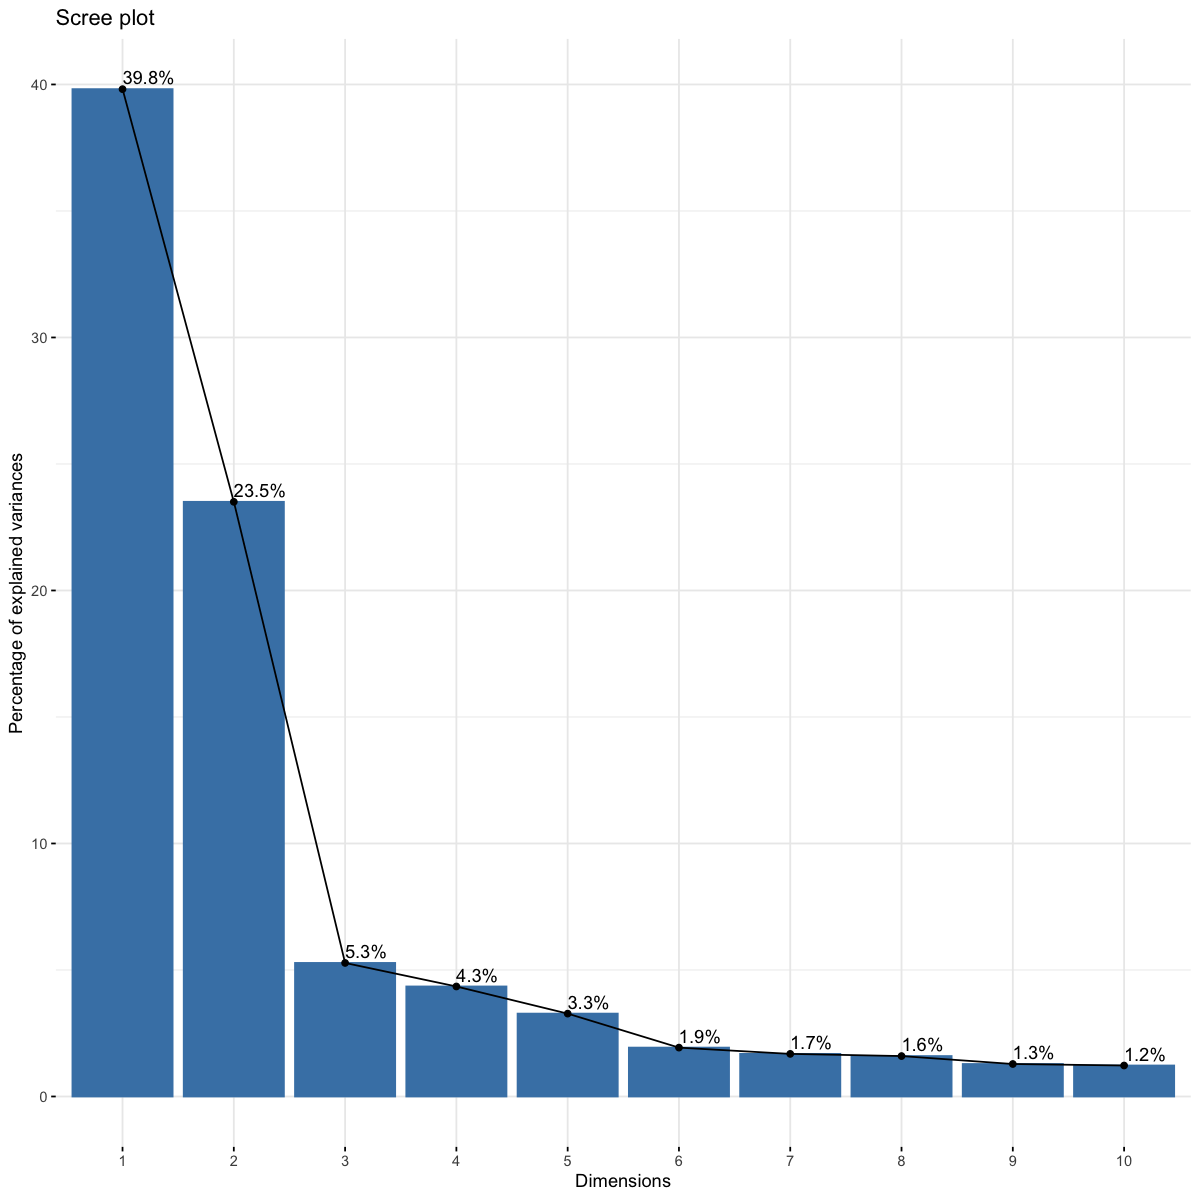

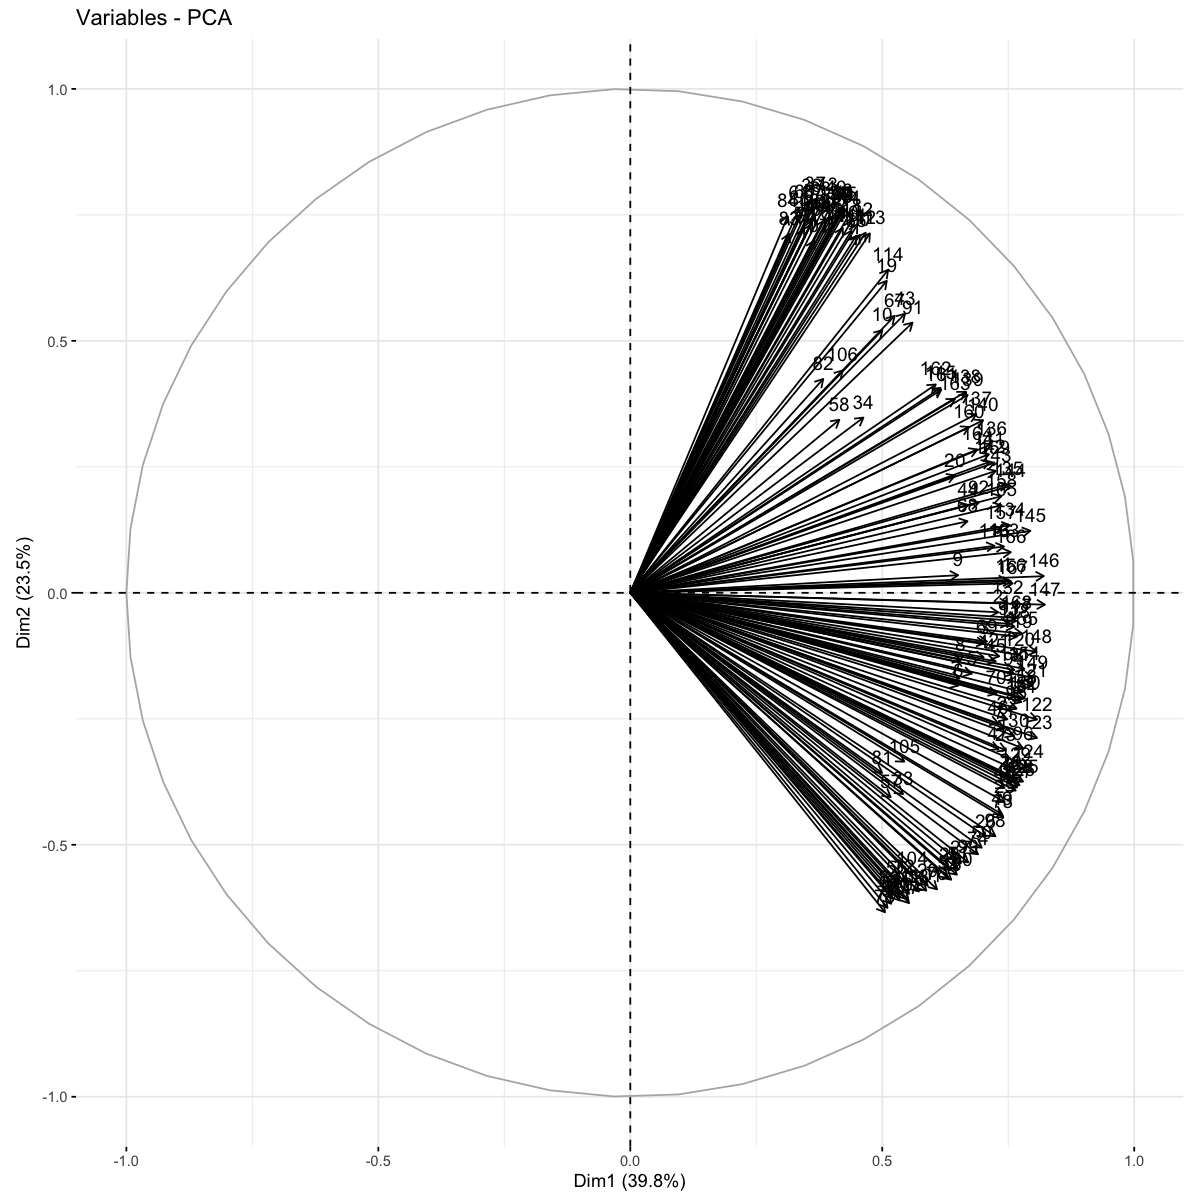

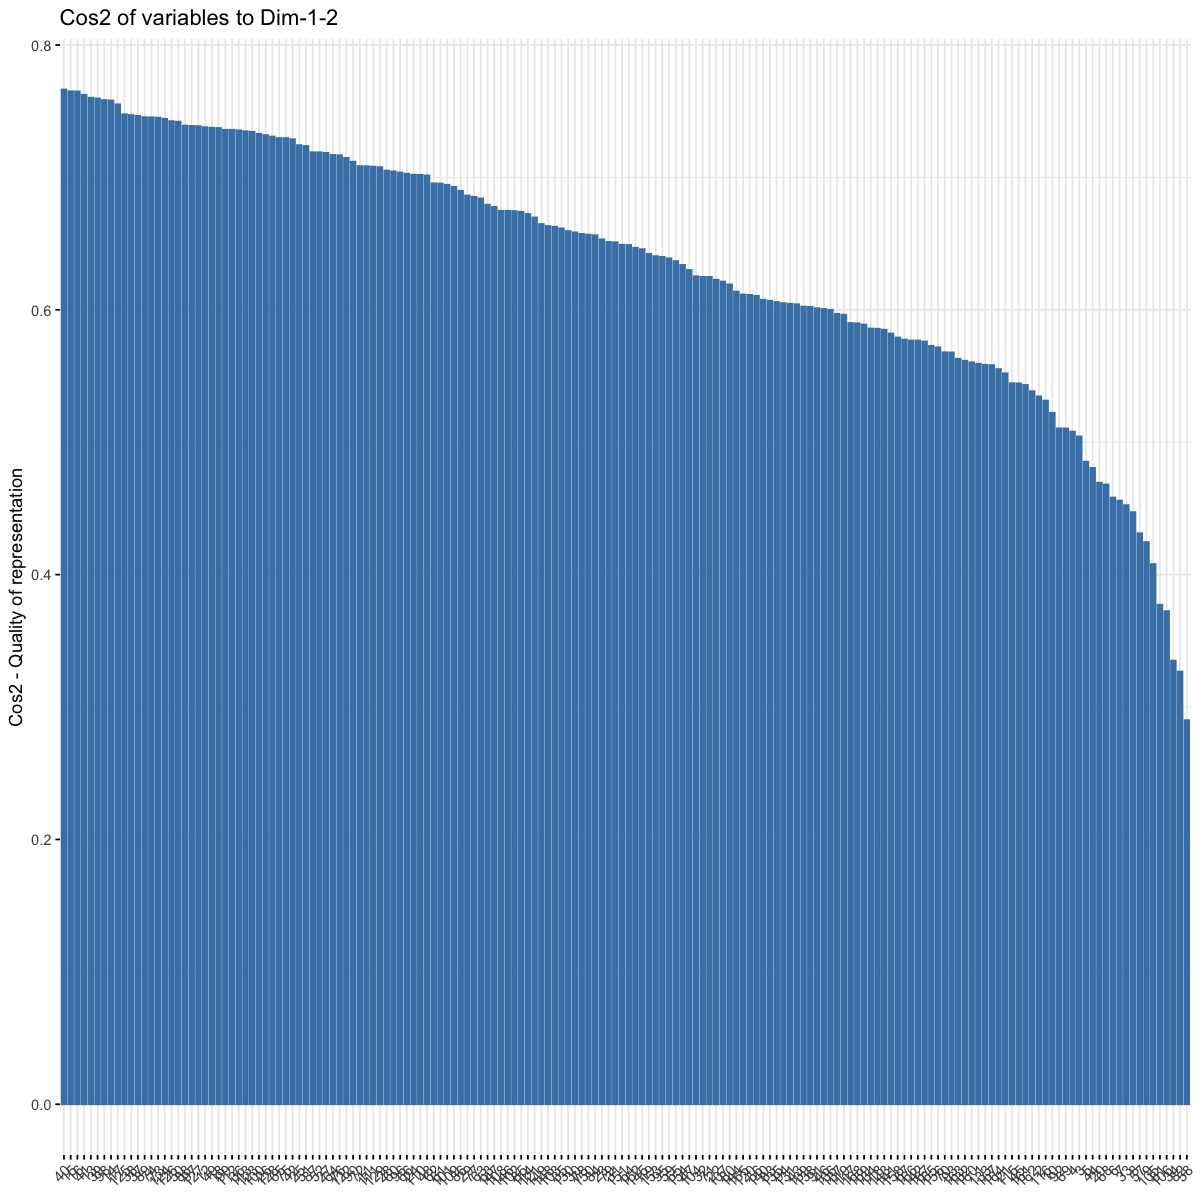

In [50]:
# Standardize the numeric variables
scaled_df <- scale(df)

# Compute the correlation matrix
corr_matrix <- cor(scaled_df)
ggcorrplot(corr_matrix)

# Perform PCA
pca_result <- prcomp(scaled_df, scale. = TRUE)

# Summary of PCA
summary(pca_result)

# Scree plot
fviz_eig(pca_result, addlabels = TRUE)

# Biplot graph of the variables
fviz_pca_var(pca_result, col.var = "black")

# Contribution of each variable
fviz_cos2(pca_result, choice = "var", axes = 1:2)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e02fb62f-9e83-46dd-b137-781014a18ec6' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>